In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import LogisticRegression as LogR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.cross_validation import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error
from math import sqrt
import xgboost as xgb

%matplotlib inline
sns.set()

/home/laksh/ml/local/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/laksh/ml/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('./dataset.csv', sep=';')

In [3]:
df.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
0,988681,L6,Monday,17,1,2111,31672;0,6,7037,\N
1,988680,L2,Thursday,22,10,2113,31965;0,2,49,14
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14
3,988678,L3,Saturday,19,8,2113,51462,6,0,1
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3


In [4]:
df.tail()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
988676,5,L2,Tuesday,18,2,2113,44232;0,2,5,\N
988677,4,L6,Tuesday,9,6,2113,38715;0;40057;31657,2,35,\N
988678,3,L2,Sunday,17,8,2114,15466;0,6,1011,\N
988679,2,L3,Monday,17,13,2113,531228;0,2,132,\N
988680,1,L4,Thursday,15,1,2116,76673;0,2,4544,18


In [5]:
df = df.iloc[::-1].reset_index(drop=True)
df.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
0,1,L4,Thursday,15,1,2116,76673;0,2,4544,18
1,2,L3,Monday,17,13,2113,531228;0,2,132,\N
2,3,L2,Sunday,17,8,2114,15466;0,6,1011,\N
3,4,L6,Tuesday,9,6,2113,38715;0;40057;31657,2,35,\N
4,5,L2,Tuesday,18,2,2113,44232;0,2,5,\N


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988681 entries, 0 to 988680
Data columns (total 10 columns):
row_num              988681 non-null int64
locale               988681 non-null object
day_of_week          988681 non-null object
hour_of_day          988681 non-null int64
agent_id             988681 non-null int64
entry_page           988681 non-null int64
path_id_set          983792 non-null object
traffic_type         988681 non-null int64
session_durantion    988681 non-null object
hits                 988681 non-null object
dtypes: int64(5), object(5)
memory usage: 75.4+ MB


In [7]:
total_count = df['hits'].count()
missing = df['hits'].value_counts()['\N']
useful = total_count - missing

print "Total number of values in 'hits' column: %d (%d%%)" % (total_count, (total_count/ total_count) * 100)
print "Training Values:                         %d (%.2f%%)" % (useful, (useful/float(total_count))*100)
print "Testing Values:                          %d (%.2f%%)" % (missing, (missing/float(total_count))*100)

Total number of values in 'hits' column: 988681 (100%)
Training Values:                         619235 (62.63%)
Testing Values:                          369446 (37.37%)


In [8]:
# for ix in df['agent_id'].unique():
#     print "###########################################\n", ix
#     print(df[df['agent_id'] == ix]['hits'].value_counts().sort_index())

In [9]:
train = df[df['hits'] != '\\N'].reset_index(drop=True)
test = df[df['hits'] == '\\N'].reset_index(drop=True)

In [10]:
train.describe()

,row_num,hour_of_day,agent_id,entry_page,traffic_type
count,619235.000000,619235.000000,619235.000000,619235.000000,619235.000000
mean,494098.480154,13.192517,7.431804,2261.892047,2.713186
std,285454.273535,6.766696,3.980112,797.624728,1.882351
min,1.000000,0.000000,0.000000,2100.000000,1.000000
25%,246820.500000,8.000000,2.000000,2111.000000,1.000000
50%,493923.000000,14.000000,9.000000,2113.000000,2.000000
75%,741286.500000,19.000000,10.000000,2116.000000,4.000000
max,988680.000000,23.000000,15.000000,8101.000000,10.000000


In [11]:
train = train.replace('\\N', np.nan)

In [14]:
train.isnull().sum()

row_num                 0
locale                  0
day_of_week             0
hour_of_day             0
agent_id                0
entry_page              0
path_id_set          3153
traffic_type            0
session_durantion     414
hits                    0
dtype: int64

In [15]:
train['session_isnull'] = train['session_durantion'] == np.nan
train['path_isnull'] = train['path_id_set'] == np.nan

In [13]:
train['session_durantion'] = train['session_durantion'].apply(pd.to_numeric, errors='coerce')
train['hits'] = train['hits'].apply(pd.to_numeric, errors='coerce')

In [18]:
train = train.replace(np.nan, -999)

In [19]:
train_df = train.copy()

In [20]:
column_list  = ['row_num', 'locale', 'day_of_week', 'hour_of_day', 'path_id_set', 'agent_id', 'entry_page', 'traffic_type', 'session_durantion', 'hits']

In [21]:
freq_encoding = train_df.groupby('locale').size()
freq_encoding = freq_encoding / len(train_df)
train_df['locale_enc'] = train_df.locale.map(freq_encoding)

freq_encoding = train_df.groupby('traffic_type').size()
freq_encoding = freq_encoding / len(train_df)
train_df['traffic_enc'] = train_df.traffic_type.map(freq_encoding)

In [22]:
label_dict = {'Monday': float(0)/7, 'Tuesday': float(1)/7, 'Wednesday': float(2)/7, 'Thursday': float(3)/7,
              'Friday': float(4)/7, 'Saturday': float(5)/7, 'Sunday': float(6)/7}

In [23]:
train_df['week_enc'] = train_df['day_of_week']
for day in train_df['day_of_week'].unique():
    train_df['week_enc'] = train_df['week_enc'].replace(day, label_dict[day])

In [24]:
hours_in_day = 24
# train_df['hr_sin'] = np.sin(train_df.hour_of_day*(2.*np.pi/hours_in_day))
# train_df['hr_cos'] = np.cos(train_df.hour_of_day*(2.*np.pi/hours_in_day))

train_df['combined_sin'] = np.sin(train_df.week_enc*(train_df.hour_of_day*(2.*np.pi/hours_in_day)))
train_df['combined_cos'] = np.cos(train_df.week_enc*(train_df.hour_of_day*(2.*np.pi/hours_in_day)))

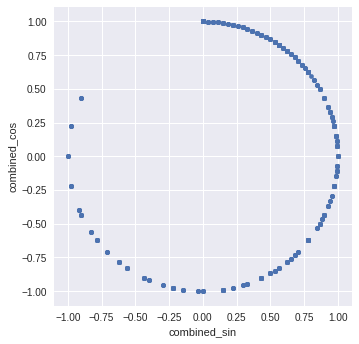

In [25]:
train_df.sample(1000).plot.scatter('combined_sin', 'combined_cos').set_aspect('equal')

In [26]:
# imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
# test_df['hits'] = imp.fit_transform(pd.DataFrame(test_df['hits']))

In [27]:
# test_df.loc[::, 'day_hits'] = test_df.loc[::, 'hits'].groupby(test_df['day_of_week']).transform('mean')

# test_df.loc[::, 'hour_hits'] = test_df.loc[::, 'hits'].groupby(test_df['hour_of_day']).transform('mean')

# test_df.loc[::, 'locale_hits'] = test_df.loc[::, 'hits'].groupby(test_df['locale']).transform('mean')

# test_df.loc[::, 'traffic_hits'] = test_df.loc[::, 'hits'].groupby(test_df['traffic_type']).transform('mean')

# test_df.loc[::, 'agent_hits'] = test_df.loc[::, 'hits'].groupby(test_df['agent_id']).transform('mean')

# test_df.loc[::, 'entry_hits'] = test_df.loc[::, 'hits'].groupby(test_df['entry_page']).transform('mean')

In [28]:
train_df.loc[::, 'count_page'] = train_df.loc[::, 'path_id_set'].apply(lambda x: len(x.split(';')) if isinstance(x, basestring) else 0)

In [29]:
# days = test_df['day_of_week']
# test_df = test_df.join(pd.get_dummies(days))

In [30]:
# l = test_df['locale']
# test_df = test_df.join(pd.get_dummies(l))

In [31]:
# le = LabelEncoder()
# test_df.iloc[:, 1] = le.fit_transform(test_df.iloc[:, 1])

In [32]:
# test_df.iloc[:, 2] = le.fit_transform(test_df.iloc[:, 2])

In [33]:
# imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
# train_df['session_durantion'] = train_df['session_durantion'].apply(pd.to_numeric, errors='coerce')
# train_df['session_durantion'] = imp.fit_transform(pd.DataFrame(train_df['session_durantion']))

# test_df = test_df.fillna(method='ffill')
# imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
# test_df.iloc[:, 8:9] = imp.fit_transform(test_df.iloc[:, 8:9])
# test_df.iloc[:, 7:8] = imp.fit_transform(test_df.iloc[:, 7:8])

In [34]:
col1 = train_df['entry_page'] * train_df['session_durantion']
train_df.insert(loc=1, column='col1', value=col1)

# col2 = train_df['agent_id'] * train_df['traffic_type']
# train_df.insert(loc=2, column='col2', value=col2)

# col3 = train_df['traffic_type'] * train_df['session_durantion']
# train_df.insert(loc=3, column='col3', value=col3)

# col4 = train_df['hour_of_day'] * train_df['session_durantion']
# train_df.insert(loc=4, column='col4', value=col4)

# col5 = train_df['traffic_type'] * train_df['session_durantion'] * train_df['agent_id']
# train_df.insert(loc=5, column='col5', value=col5)

# col6 = train_df['entry_page'] * train_df['session_durantion']
# train_df.insert(loc=6, column='col6', value=col6)

# col7 = train_df['entry_page'] * train_df['count_page']
# train_df.insert(loc=7, column='col7', value=col7)

# col8 = train_df['session_durantion'] / train_df['count_page']
# col8.fillna(0, inplace=True)
# train_df.insert(loc=8, column='col8', value=col8)

In [35]:
# test_df = test_df.dropna()

In [36]:
train_df.head(1)

,row_num,col1,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits,session_isnull,path_isnull,locale_enc,traffic_enc,week_enc,combined_sin,combined_cos,count_page
0,1,9615104.0,L4,Thursday,15,1,2116,76673;0,2,4544.0,18,False,False,0.139096,0.324229,0.428571,0.993712,-0.111964,2


In [37]:
train_df.columns

Index([u'row_num', u'col1', u'locale', u'day_of_week', u'hour_of_day',
       u'agent_id', u'entry_page', u'path_id_set', u'traffic_type',
       u'session_durantion', u'hits', u'session_isnull', u'path_isnull',
       u'locale_enc', u'traffic_enc', u'week_enc', u'combined_sin',
       u'combined_cos', u'count_page'],
      dtype='object')

In [38]:
X = train_df.drop(['hits', 'day_of_week', 'locale', 'path_id_set', 'traffic_type'], axis=1)
y = pd.DataFrame(train_df['hits'])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [74]:
xgdmat=xgb.DMatrix(X_train,y_train)
our_params={'eta':0.1,'seed':0,'subsample':0.8,'colsample_bytree':0.8,'objective':'reg:linear','max_depth':3,'min_child_weight':1}
final_gb=xgb.train(our_params,xgdmat)
tesdmat=xgb.DMatrix(X_test)
y_pred=final_gb.predict(tesdmat)
# print(y_pred)

In [75]:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print rmse

34.0577132784


In [65]:
# n_folds = 5
# early_stopping = 10
# params = {'eta': 0.02, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'objective': 'gpu:reg:linear', 'seed': 99, 'silent': 1, 'eval_metric':'rmse'}

# xg_train = xgb.DMatrix(X_train, label=y_train);

# cv = xgb.cv(params, xg_train, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1,
#            callbacks=[xgb.callback.print_evaluation(show_stdv=True)])

In [68]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'silent': 1,
    'objective':'gpu:reg:linear',
}

params['eval_metric'] = "rmse"
num_boost_round = 999

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)


[0]	Test-rmse:37.6724
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:34.8315
[2]	Test-rmse:33.2739
[3]	Test-rmse:32.4761
[4]	Test-rmse:32.0215
[5]	Test-rmse:31.7881
[6]	Test-rmse:31.642
[7]	Test-rmse:31.5708
[8]	Test-rmse:31.5508
[9]	Test-rmse:31.5351
[10]	Test-rmse:31.5445
[11]	Test-rmse:31.5518
[12]	Test-rmse:31.5737
[13]	Test-rmse:31.5948
[14]	Test-rmse:31.6307
[15]	Test-rmse:31.6421
[16]	Test-rmse:31.6305
[17]	Test-rmse:31.6309
[18]	Test-rmse:31.6317
[19]	Test-rmse:31.6596
Stopping. Best iteration:
[9]	Test-rmse:31.5351



In [69]:
print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best MAE: 31.54 with 10 rounds


In [71]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)

cv_results

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
0,37.927458,2.178853,37.839212,0.539927
1,35.127283,2.310416,34.884294,0.547114
2,33.612875,2.355770,33.220571,0.540045
3,32.809079,2.392658,32.250405,0.518346
4,32.383455,2.384740,31.658708,0.489666
5,32.173855,2.388933,31.288584,0.504364
6,32.051896,2.385017,31.063136,0.501389
7,31.974285,2.361917,30.868604,0.498810
8,31.916456,2.350015,30.663959,0.455014
9,31.899625,2.365322,30.475862,0.448369


In [73]:
cv_results['test-rmse-mean'].min()

31.8985626

In [78]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(8,18)
    for min_child_weight in range(5,15)
]

In [79]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )

    # Update best MAE
    mean_mae = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=8, min_child_weight=5
	MAE 31.9219562 for 12 rounds
CV with max_depth=8, min_child_weight=6
	MAE 31.9304926 for 11 rounds
CV with max_depth=8, min_child_weight=7
	MAE 31.8973852 for 9 rounds
CV with max_depth=8, min_child_weight=8
	MAE 31.8949522 for 11 rounds
CV with max_depth=8, min_child_weight=9


KeyboardInterrupt: 

In [80]:
params['max_depth'] = 9
params['min_child_weight'] = 7

In [81]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_rmse = float("Inf")
best_params = None

# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))

    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )

    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)

print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	rmse 32.0001484 for 12 rounds
CV with subsample=1.0, colsample=0.9
	rmse 31.9963056 for 8 rounds
CV with subsample=1.0, colsample=0.8
	rmse 32.035028 for 9 rounds
CV with subsample=1.0, colsample=0.7
	rmse 32.0661808 for 8 rounds
CV with subsample=0.9, colsample=1.0
	rmse 32.0113504 for 7 rounds
CV with subsample=0.9, colsample=0.9
	rmse 32.055843 for 8 rounds
CV with subsample=0.9, colsample=0.8
	rmse 32.0833938 for 9 rounds
CV with subsample=0.9, colsample=0.7
	rmse 32.0263866 for 9 rounds
CV with subsample=0.8, colsample=1.0
	rmse 32.0102432 for 9 rounds
CV with subsample=0.8, colsample=0.9
	rmse 32.0054184 for 9 rounds
CV with subsample=0.8, colsample=0.8
	rmse 32.0470488 for 9 rounds
CV with subsample=0.8, colsample=0.7
	rmse 32.0715634 for 9 rounds
CV with subsample=0.7, colsample=1.0
	rmse 32.161385 for 8 rounds
CV with subsample=0.7, colsample=0.9
	rmse 32.0607572 for 8 rounds
CV with subsample=0.7, colsample=0.8
	rmse 32.0818986 for 8 roun

In [82]:
params['subsample'] = 1.
params['colsample_bytree'] = .9

In [83]:
%time

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


In [89]:
# This can take some time…
min_rmse = float("Inf")
best_params = None

for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))

    # We update our parameters
    params['eta'] = eta

    # Run and time CV
    %time cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics=['rmse'], early_stopping_rounds=10)

    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta

print("Best params: {}, rmse: {}".format(best_params, min_rmse))

CV with eta=0.3
CPU times: user 2min 8s, sys: 308 ms, total: 2min 8s
Wall time: 22 s
	rmse 31.9963056 for 8 rounds

CV with eta=0.2
CPU times: user 2min 55s, sys: 428 ms, total: 2min 55s
Wall time: 30 s
	rmse 31.9892054 for 14 rounds

CV with eta=0.1
CPU times: user 5min 25s, sys: 544 ms, total: 5min 26s
Wall time: 54.1 s
	rmse 31.846317 for 35 rounds

CV with eta=0.05
CPU times: user 10min 31s, sys: 920 ms, total: 10min 31s
Wall time: 1min 43s
	rmse 31.8225528 for 79 rounds

CV with eta=0.01
CPU times: user 43min 52s, sys: 3.32 s, total: 43min 56s
Wall time: 7min 10s
	rmse 31.8121636 for 360 rounds

CV with eta=0.005
CPU times: user 1h 25min 22s, sys: 6.72 s, total: 1h 25min 29s
Wall time: 13min 52s
	rmse 31.7988136 for 709 rounds

Best params: 0.005, rmse: 31.7988136


In [91]:
params['eta'] = .02

In [92]:
params

{'colsample_bytree': 0.9,
 'eta': 0.02,
 'eval_metric': 'rmse',
 'max_depth': 9,
 'min_child_weight': 7,
 'objective': 'gpu:reg:linear',
 'silent': 1,
 'subsample': 1.0}

In [94]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=20
)

print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-rmse:42.3842
Will train until Test-rmse hasn't improved in 20 rounds.
[1]	Test-rmse:42.0107
[2]	Test-rmse:41.6514
[3]	Test-rmse:41.3015
[4]	Test-rmse:41.0032
[5]	Test-rmse:40.6775
[6]	Test-rmse:40.3987
[7]	Test-rmse:40.1287
[8]	Test-rmse:39.8226
[9]	Test-rmse:39.5371
[10]	Test-rmse:39.2584
[11]	Test-rmse:38.9869
[12]	Test-rmse:38.7242
[13]	Test-rmse:38.5048
[14]	Test-rmse:38.2545
[15]	Test-rmse:38.0449
[16]	Test-rmse:37.8097
[17]	Test-rmse:37.5859
[18]	Test-rmse:37.3674
[19]	Test-rmse:37.1526
[20]	Test-rmse:36.9469
[21]	Test-rmse:36.7475
[22]	Test-rmse:36.5563
[23]	Test-rmse:36.3963
[24]	Test-rmse:36.2172
[25]	Test-rmse:36.0684
[26]	Test-rmse:35.9016
[27]	Test-rmse:35.7382
[28]	Test-rmse:35.5815
[29]	Test-rmse:35.4313
[30]	Test-rmse:35.2854
[31]	Test-rmse:35.1648
[32]	Test-rmse:35.0289
[33]	Test-rmse:34.9167
[34]	Test-rmse:34.7898
[35]	Test-rmse:34.6683
[36]	Test-rmse:34.5497
[37]	Test-rmse:34.4363
[38]	Test-rmse:34.3245
[39]	Test-rmse:34.2183
[40]	Test-rmse:34.1306
[41]	Test-

In [96]:
num_boost_round = model.best_iteration + 1

best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-rmse:42.3842
[1]	Test-rmse:42.0107
[2]	Test-rmse:41.6514
[3]	Test-rmse:41.3015
[4]	Test-rmse:41.0032
[5]	Test-rmse:40.6775
[6]	Test-rmse:40.3987
[7]	Test-rmse:40.1287
[8]	Test-rmse:39.8226
[9]	Test-rmse:39.5371
[10]	Test-rmse:39.2584
[11]	Test-rmse:38.9869
[12]	Test-rmse:38.7242
[13]	Test-rmse:38.5048
[14]	Test-rmse:38.2545
[15]	Test-rmse:38.0449
[16]	Test-rmse:37.8097
[17]	Test-rmse:37.5859
[18]	Test-rmse:37.3674
[19]	Test-rmse:37.1526
[20]	Test-rmse:36.9469
[21]	Test-rmse:36.7475
[22]	Test-rmse:36.5563
[23]	Test-rmse:36.3963
[24]	Test-rmse:36.2172
[25]	Test-rmse:36.0684
[26]	Test-rmse:35.9016
[27]	Test-rmse:35.7382
[28]	Test-rmse:35.5815
[29]	Test-rmse:35.4313
[30]	Test-rmse:35.2854
[31]	Test-rmse:35.1648
[32]	Test-rmse:35.0289
[33]	Test-rmse:34.9167
[34]	Test-rmse:34.7898
[35]	Test-rmse:34.6683
[36]	Test-rmse:34.5497
[37]	Test-rmse:34.4363
[38]	Test-rmse:34.3245
[39]	Test-rmse:34.2183
[40]	Test-rmse:34.1306
[41]	Test-rmse:34.0331
[42]	Test-rmse:33.9385
[43]	Test-rmse:33.845

In [100]:
sqrt(mean_squared_error(best_model.predict(dtest), y_test))
best_model.save_model("my_model_31.53.model")

In [104]:
sorted(best_model.get_fscore().items(), key=lambda kv: kv[1], reverse=True)

[('col1', 9897),
 ('entry_page', 8048),
 ('agent_id', 6713),
 ('row_num', 6320),
 ('session_durantion', 5935),
 ('count_page', 5503),
 ('traffic_enc', 4118),
 ('combined_sin', 3808),
 ('locale_enc', 3729),
 ('hour_of_day', 3711),
 ('combined_cos', 2722),
 ('week_enc', 1466)]

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf_linear = LR()
clf_linear.fit(X_train, y_train)

# y_predicted = clf_linear.predict(X_test)
# y_actual = y_test

# mse = mean_squared_error(y_actual, y_predicted)
# rmse = sqrt(mse)
# print rmse
scores = cross_val_score(clf_linear, X_train, y_train, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
print sqrt(-np.mean(scores)), [sqrt(-x) for x in scores]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [704]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# clf_logistic = LogR(solver='sag', n_jobs=-1)
# clf_logistic.fit(X_train, y_train.values.ravel())

# scores = cross_val_score(clf_logistic, X_train, y_train, cv=5)

# print np.mean(scores), scores

In [705]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf_forest = RFR(n_jobs=-1)
clf_forest.fit(X_train, y_train.values.ravel())

scores = cross_val_score(clf_forest, X_train, y_train.values.ravel(), cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
print sqrt(-np.mean(scores)), [sqrt(-x) for x in scores] 

34.5203494628 [35.13823911433399, 35.10587120913616, 34.99130913401764, 32.832695834867216, 33.68360098467289, 32.37407721330077, 33.6037688563602, 32.85252999911645, 31.163467533104356, 42.24594690771168]


In [706]:
rf_features = zip(X_train.columns, clf_forest.feature_importances_)
rf_features.sort(key = lambda x: x[1], reverse= True)
for ix, imp in rf_features:
    print ix, '----', imp*100

col1 ---- 22.35942604195735
session_durantion ---- 20.36329157156105
row_num ---- 14.265051003695392
count_page ---- 10.711785713108176
hour_of_day ---- 5.55212454017876
combined_sin ---- 5.518090029400267
combined_cos ---- 4.768321395057552
agent_id ---- 4.471803622518184
locale_enc ---- 4.097786355519753
week_enc ---- 3.052237022573458
entry_page ---- 3.0158911735632343
traffic_enc ---- 1.8241915308668248


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf_gbr = GBR()
clf_gbr.fit(X_train, y_train.values.ravel())

scores = cross_val_score(clf_gbr, X_train, y_train.values.ravel(), cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
print sqrt(-np.mean(scores)), [sqrt(-x) for x in scores]

31.9987724515 [32.47650183826232, 32.593213192397485, 32.27366166601097, 31.242504748890642, 31.471526238074542, 28.695444715744006, 31.549178901587492, 30.1209251396868, 27.788109395233818, 40.197076638735226]


In [40]:
features = zip(X_train.columns, clf_gbr.feature_importances_)
features.sort(key = lambda x: x[1], reverse= True)
for ix, imp in features:
    print ix, '----', imp*100

session_durantion ---- 32.13337752823812
count_page ---- 26.269998164836295
col1 ---- 16.80445992093598
entry_page ---- 9.804928901488896
traffic_enc ---- 7.345856872536554
agent_id ---- 3.1348725762400385
row_num ---- 1.2825427554906674
combined_cos ---- 1.1272207343587224
combined_sin ---- 1.006756647042725
hour_of_day ---- 0.85608594044168
locale_enc ---- 0.23312500354086513
week_enc ---- 0.0007749548494378182
session_isnull ---- 0.0
path_isnull ---- 0.0


In [600]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf_br = BaggingRegressor()
clf_br.fit(X_train, y_train.values.ravel())

scores = cross_val_score(clf_br, X_train, y_train.values.ravel(), cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
print sqrt(-np.mean(scores)), [sqrt(-x) for x in scores]

34.4526944151 [34.9374954738846, 34.87702457578139, 34.899667338692765, 33.44326112855005, 33.78662753869747, 32.00886688266321, 33.60905935943544, 33.22080032797466, 30.855786204167362, 41.77360229647135]


In [601]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf_etr = ExtraTreesRegressor()
clf_etr.fit(X_train, y_train.values.ravel())

scores = cross_val_score(clf_etr, X_train, y_train.values.ravel(), cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
print sqrt(-np.mean(scores)), [sqrt(-x) for x in scores]

35.1948363587 [35.751394187676794, 36.798377159796594, 35.18732714709731, 33.759957753579016, 34.21838956377137, 31.89969727451943, 35.7672317906423, 33.750876679419555, 31.476243157205943, 42.17748540988841]


In [602]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf_abr = AdaBoostRegressor()
clf_abr.fit(X_train, y_train.values.ravel())

scores = cross_val_score(clf_abr, X_train, y_train.values.ravel(), cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
print sqrt(-np.mean(scores)), [sqrt(-x) for x in scores]

157.004455767 [259.22215978620676, 104.67547901615235, 162.53890716060098, 43.06877754271152, 129.71158653575432]


In [603]:
clf_abr.feature_importances_

array([0.08572466, 0.22683047, 0.00483487, 0.05057294, 0.07722498,
       0.36773094, 0.01069978, 0.03925814, 0.0078085 , 0.01197728,
       0.1102905 , 0.00704696])